<a href="https://colab.research.google.com/github/DavidJimenez10/CV-Deep-Learning/blob/main/create_tf_record.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pwd
!cp "/gdrive/MyDrive/Jax Diffusers/mimic_test_impressions.csv" /content
!cp "/gdrive/MyDrive/Jax Diffusers/mimic_train_impressions.csv" /content

/content


In [ ]:
!tar -xf "/gdrive/MyDrive/Jax Diffusers/mimic_dset.tar.xz" -C /content

In [ ]:
"""
This script converts the MIMIC-CXR dataset images in JPG format and the "report" string-field from the .cvs of PRO-CRX to a TFRecord format.

Inside this kaggle you can find the MIMIC-CXR dataset in JPG version (mimic_dset folder)
https://www.kaggle.com/datasets/financekim/curated-cxr-report-generation-dataset


Inside this HF dataset you can find the .csv
https://huggingface.co/datasets/rajpurkarlab/CXR-PRO



Useful links TFRecords
https://www.tensorflow.org/tutorials/load_data/tfrecord
https://www.youtube.com/watch?v=tk7cniyvH6c
"""
import pandas as pd
import numpy as np
import tensorflow as tf

import IPython.display as display
from os import listdir


def _bytes_feature(value):
  """
  This function convert a string to a BytesList type
  """
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_tf_example(image, report):
  """
  This function creates a tf record with 2 features image, report
  """
  report = report.encode('utf-8')

  feature = {
      'image': _bytes_feature(image),
      'report': _bytes_feature(report)
  }

  tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
  return tf_example


# Reading csv file from PRO-CXR
df_pro_cxr_reports = pd.concat([pd.read_csv('mimic_test_impressions.csv', usecols=['study_id', 'report'], dtype={'study_id':str, 'report':str}),
                               pd.read_csv('mimic_train_impressions.csv', usecols=['study_id', 'report'], dtype={'study_id':str, 'report':str})], axis=0)

#Filtering out rows with null reports
df_pro_cxr_reports = df_pro_cxr_reports[df_pro_cxr_reports['report'].notnull()]

#It's important to note that the study_id field with an 's' is the name of the images in the mimic_dset
char = 's'
df_pro_cxr_reports['study_id'] = df_pro_cxr_reports['study_id'].apply(lambda x: char + x)

#There is an inconsistency because the csv files have 318625 records and the mimic_dset have 91908 images
mimic_cxr_folder = 'mimic_dset'

#Les's match the images with the reports and the images
np_study_id_pro_cxr = df_pro_cxr_reports['study_id'].to_numpy(dtype='str')
#First we save the name of mimic_dset images
images = []
for image_name in listdir(mimic_cxr_folder):
    if image_name.endswith('.jpg'):
        images.append(image_name.split('.')[0])

np_study_id_mimic_cxr = np.array(images)
print(f'mimic: {np_study_id_mimic_cxr.size}\npro_cxr: {np_study_id_pro_cxr.size}')

#We find the common elements
common_elements = np.intersect1d(np_study_id_mimic_cxr, np_study_id_pro_cxr)
print(f'Common elements: {common_elements.size}')

#Now we can filter the records keeping only the ones with images
df_pro_cxr_reports= df_pro_cxr_reports[df_pro_cxr_reports['study_id'].isin(common_elements)]
print(f'Filtered df_pro_cxr_reports: {len(df_pro_cxr_reports)}')

#Let's create a tfrecord file
with tf.io.TFRecordWriter(f'controlnet_cxr.tfrecord') as writer:
    for image_name, report in zip(df_pro_cxr_reports['study_id'].to_numpy(dtype='str'), df_pro_cxr_reports['report'].to_numpy(dtype='str')):
      image = open(f'{mimic_cxr_folder}/{image_name}.jpg', 'rb').read()
      tf_example = create_tf_example(image, report)
      writer.write(tf_example.SerializeToString())
#We get a file of 1.7GB 


mimic: 91908
pro_cxr: 318625
Common elements: 69686
Filtered df_pro_cxr_reports: 69686


In [ ]:
import tensorflow as tf
from PIL import Image
from io import BytesIO
# For colab
# import IPython.display as display

raw_image_dataset = tf.data.TFRecordDataset('controlnet_cxr.tfrecord')

# Create a dictionary describing the features.
image_feature_description = {
    'report': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

cont = 0
for image_features in parsed_image_dataset:
    image_raw = image_features['image'].numpy()
    # For Colab
    # display.display(display.Image(data=image_raw))
    image_raw = Image.open(BytesIO(image_raw))
    image_raw.show()
    print(image_features['report'])
    cont += 1
    if cont > 4:
        break


NameError: ignored

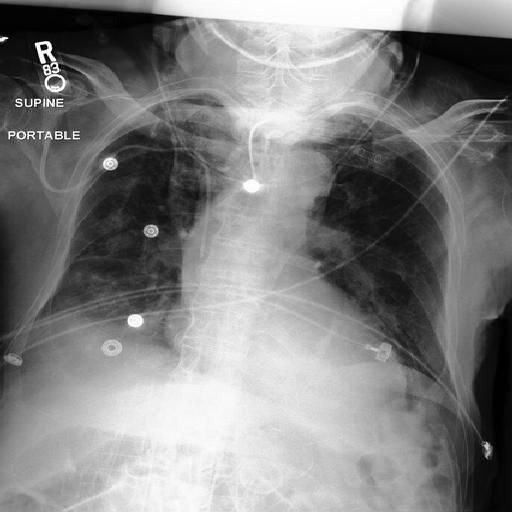

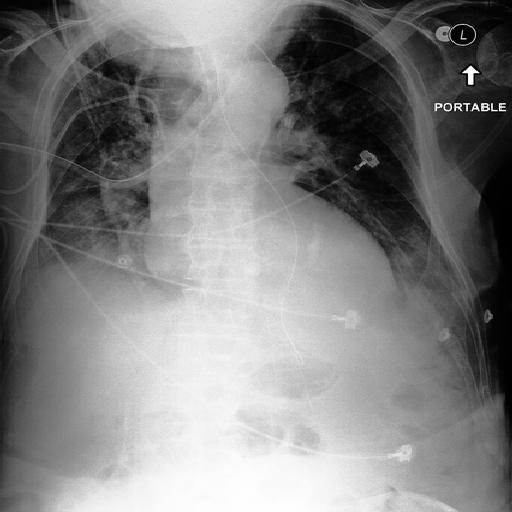

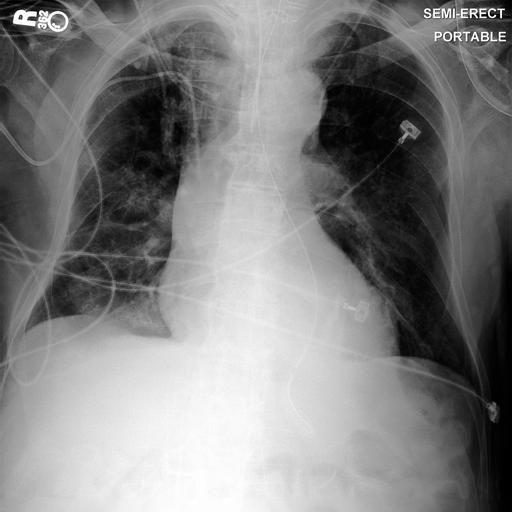

In [ ]:
from google.colab.patches import cv2_imshow
images = ['s51178141', 's54397816', 's57870796']
mimic_cxr_folder = 'mimic_dset'
for image_name in images:
  image = cv2.imread(f'{mimic_cxr_folder}/{image_name}.jpg')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  cv2_imshow(image)

In [ ]:
filenames = ['controlnet_cxr.tfrecord']
raw_dataset = tf.data.TFRecordDataset(filenames)
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\002\000\002\000\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\247\250\251\25

In [ ]:
import tensorflow as tf
from PIL import Image
from io import BytesIO


raw_image_dataset = tf.data.TFRecordDataset('/gdrive/MyDrive/Jax Diffusers/controlnet_cxr.tfrecord')

# Create a dictionary describing the features.
image_feature_description = {
  'report': tf.io.FixedLenFeature([], tf.string),
  'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
print(parsed_image_dataset)
dict_dataset = {'image': [], 'report':[]}
for image_features in parsed_image_dataset:
  image_raw = image_features['image'].numpy()
  dict_dataset['image'].append(Image.open(BytesIO(image_raw)))
  dict_dataset['report'].append(image_features['report'])

print(f"image: {dict_dataset['image'][0]}")
print(f"report: {dict_dataset['report'][0]}")

<_MapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'report': TensorSpec(shape=(), dtype=tf.string, name=None)}>
image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F4A1C300E80>
report: b'Enlarged cardiac silhouette is accompanied by pulmonary vascular congestion and diffuse interstitial edema. Marked cardiomegaly is accompanied by pulmonary vascular congestion and mild to moderate edema. '


In [ ]:
!pip install datasets
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!huggingface-cli login
!huggingface-cli repo create CXR_Reports --type dataset


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.cache/huggingface

In [ ]:
import tensorflow as tf
import datasets
cxpro_dataset = datasets.Dataset.from_dict(dict_dataset).cast_column('image', datasets.Image())

In [ ]:
_DESCRIPTION = (
    "This dataset consists 90k images of Chest-X-Ray from the Mimic-CXR dataset."
    "For each image, we have a consise report obtain from de PRO-CXR dataset"
    "All images have a size of 512x512 pixels."
)


_BASE_URL = "https://drive.google.com/file/d/1u27GCgIIRqDz8a5-VTcMJ1pEFQbGv_QB/view?usp=sharing"

FEATURE_DESCRIPTION_TFRECORD = {
  'report': tf.io.FixedLenFeature([], tf.string),
  'image': tf.io.FixedLenFeature([], tf.string),
}


class ReportsCXR(datasets.GeneratorBasedBuilder):
  def _info(self):
    return datasets.DatasetInfo(
        description = _DESCRIPTION,
        features = datasets.Features(
            'image': datasets.Image(),
            'report': datasets.Value(dtype='string')
        )
    )
  def _get_drive_url(self, url):
        base_url = 'https://drive.google.com/uc?id='
        split_url = url.split('/')
        return base_url + split_url[5]

  def _split_generators(self, dl_manager):
    archive_path = dl_manager.download(self._get_drive_url(_BASE_URL))
    return [
        datasets.SplitGenerator(name='full', gen_kwargs={'filepath': dl_manager.iter_archive(archive_path)})
    ]

  def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

  def _generate_examples(self, filepath):
    raw_image_dataset = tf.data.TFRecordDataset(filepath)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    for image_features in parsed_image_dataset:
      image_raw = image_features['image'].numpy()
      yield {'image': image_raw, 'report': image_features['report']}



In [ ]:
from datasets import load_dataset
load_dataset("Einstellung/CXR_Reports")